Download The CSV file from Kaggle https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/overview

##**Connecting google drive and importing modules**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import csv
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Reading in csv with training data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')

In [ ]:
print(df.shape)
df.head()

#**Data Exploration**

Here we will look at the distribution of classes to see if it is balanced or imbalanced. We will also visualize some samples from the dataset to get an idea of what the images look like and whether there are any anomalies or data quality issues.

In [ ]:
df_Exploration = pd.read_csv('/content/drive/MyDrive/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')


In [ ]:
print(df_Exploration.shape)
df_Exploration.head()

(28709, 2)


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


Preprocessing to view sample images

In [ ]:
df_Exploration['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48) for x in df['pixels']]

In [ ]:
pixels = np.concatenate(df_Exploration['pixels'])
labels = df_Exploration.emotion.values

print(pixels.shape)
print(labels.shape)

(28709, 48, 48)
(28709,)


In [ ]:
emotion_prop = (df_Exploration.emotion.value_counts() / len(df_Exploration)).to_frame().sort_index(ascending=True)

emotion_prop

,emotion
0,0.139155
1,0.015187
2,0.142708
3,0.251315
4,0.168240
5,0.110453
6,0.172942


**Analysing the distribution of classes (emotions) in the dataset**

In [ ]:
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

palette = ['red', 'orange', 'green', 'gold', 'chocolate', 'blue', 'olive']

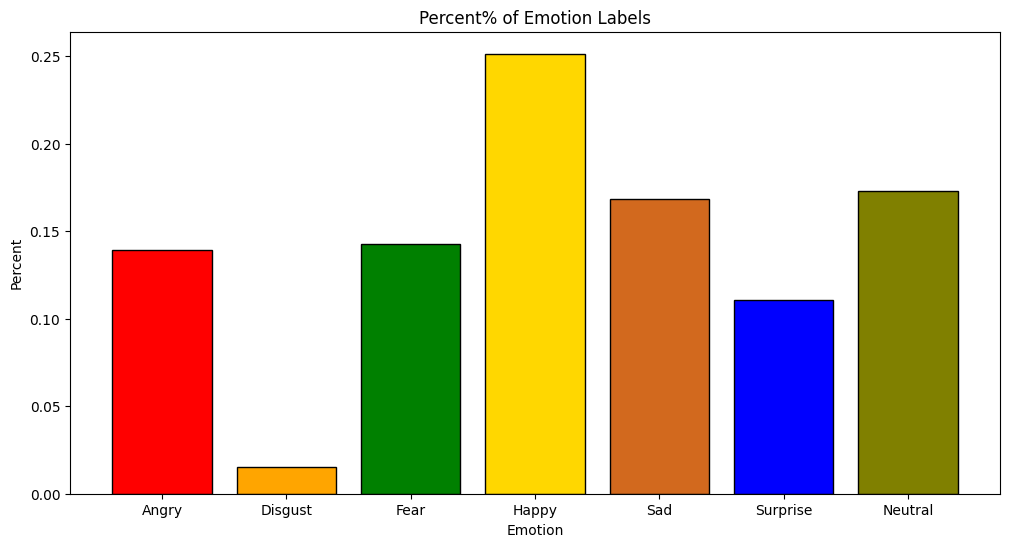

In [ ]:
plt.figure(figsize=[12,6])

plt.bar(x=emotions, height=emotion_prop['emotion'], color=palette, edgecolor='black')

plt.xlabel('Emotion')
plt.ylabel('Percent')
plt.title('Percent% of Emotion Labels')
plt.show()

**Visualising some sample images**

Sample images for each emotion: anger, disgust, fear, happy, sad, surprise, and neutral.

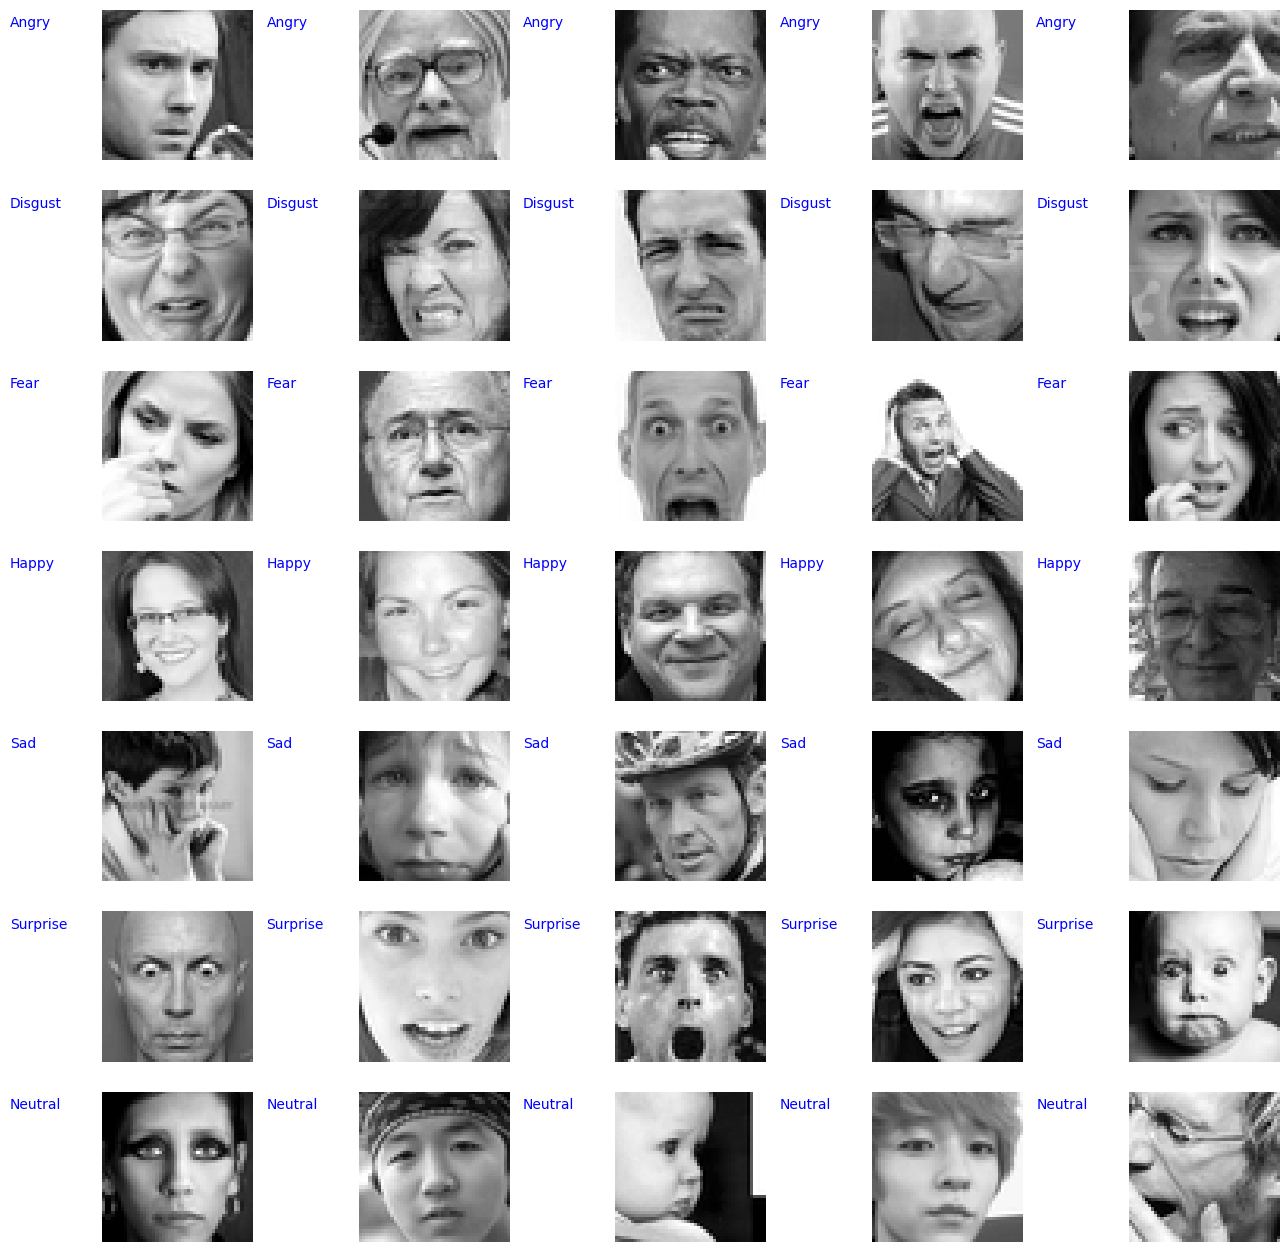

In [ ]:
plt.close()
plt.rcParams["figure.figsize"] = [16,16]

row = 0
for emotion in np.unique(df_Exploration.emotion.values):

    all_emotion_images = df_Exploration[df_Exploration['emotion'] == emotion]
    for i in range(5):

        img = all_emotion_images.iloc[i,].pixels.reshape(48,48)
        lab = emotions[emotion]

        plt.subplot(7,5,row+i+1)
        plt.imshow(img, cmap='binary_r')
        plt.text(-30, 5, s = str(lab), fontsize=10, color='b')
        plt.axis('off')
    row += 5

plt.show()

##**Data Preprocessing**

For each new dataset the image data is extracted from the DataFrame and converted into a numpy array, reshaped to a 48x48 image and cast to np.uint8. the tensor is transposed from HxWxC to CxHxW (channel-first format) to match the input format expected by the CNN.

In [ ]:

# Custom dataset class
class FERDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = np.array(eval("[" + self.data.iloc[idx].pixels.replace(" ", " ,") + "]")).reshape(48, 48, -1).astype(np.uint8)
        label = self.data.iloc[idx, 0]

        # Convert the image to a tensor
        img = torch.from_numpy(np.asarray(img))

        # Normalize the tensor (i.e. scale pixel values between 0 and 1)
        img = img.float() / 255.0

        # Permute the dimensions of the tensor (from HxWxC to CxHxW)
        img = img.permute(2, 0, 1)


        if self.transform:
            img = self.transform(img)

        return img, label

In this section the training dataset is split into training and validation datasets. Using ‘train_test_split(data, test_size=0.2, random_state=42)’ we take 20%of the data from the training set to be used for validation later in the model.

In [ ]:
def load_dataset(csv_file, transform):
    data = pd.read_csv(csv_file)
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
    train_dataset = FERDataset(train_data, transform=transform)
    val_dataset = FERDataset(val_data, transform=transform)
    return train_dataset, val_dataset

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
 ])

In [ ]:
train_dataset, val_dataset = load_dataset('/content/drive/MyDrive/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv', transform)

##**Data Augmentation**

To prevent overfitting, image augmentation is used to add additional training observations.

In [ ]:
# Defining the transformations to be applied to the training dataset
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(size=48, padding=4),
])
train_dataset.transform = train_transforms

##**Model Development**

This is the class for the CNN model consisting of two convolutional layers (conv1 and conv2), followed by two fully connected (dense) layers (fc1 and fc2).

In [ ]:
class EmotionRecognitionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionRecognitionCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2, dilation=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32 * 12 * 12, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.6)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x =
        self.fc1(x)
        x = self.fc2(x)
        return x

train and evaluate functions return the average loss and accuracy over the dataloader

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)



In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    return running_loss / len(dataloader), correct / total

Here we select the device to use, e.g. cpu, gpu. We prepare the validation, test and augmented training datasets. The CNN model is compiled using loss function, optimizer, and evaluation metric

In [ ]:
# Set device
device = 'cuda' #if torch.cuda.is_available() else 'cpu'

# Load data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
test_data = pd.read_csv('/content/drive/MyDrive/challenges-in-representation-learning-facial-expression-recognition-challenge/test2.csv')
test_dataset = FERDataset(test_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size =64, shuffle=False)

# Model, criterion, and optimizer
num_classes = 7
model = EmotionRecognitionCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metrics = ['accuracy']

Here the number of epochs can be edited. The model will be trained and loss will be reduced over each iteration. This code shows the training loss, validation loss/accuracy and test loss/accuracy for each epoch

In [ ]:
# Define empty lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training and evaluation
num_epochs = 15
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], \
    Train Loss: {train_loss:.4f}, \
    Val Loss: {val_loss:.4f}, \
    Val Accuracy: {val_accuracy:.4f}, \
    Test Loss: {test_loss:.4f}, \
    Test Accuracy: {test_accuracy:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch [1/15],     Train Loss: 1.8235,     Val Loss: 1.7601,     Val Accuracy: 0.3945,     Test Loss: 1.7651,     Test Accuracy: 0.3862
Epoch [2/15],     Train Loss: 1.7709,     Val Loss: 1.7696,     Val Accuracy: 0.3854,     Test Loss: 1.7657,     Test Accuracy: 0.3937
Epoch [3/15],     Train Loss: 1.7530,     Val Loss: 1.7452,     Val Accuracy: 0.4094,     Test Loss: 1.7444,     Test Accuracy: 0.4062
Epoch [4/15],     Train Loss: 1.7409,     Val Loss: 1.7059,     Val Accuracy: 0.4523,     Test Loss: 1.7092,     Test Accuracy: 0.4483
Epoch [5/15],     Train Loss: 1.7306,     Val Loss: 1.6802,     Val Accuracy: 0.4779,     Test Loss: 1.6925,     Test Accuracy: 0.4636
Epoch [6/15],     Train Loss: 1.7213,     Val Loss: 1.7008,     Val Accuracy: 0.4551,     Test Loss: 1.7107,     Test Accuracy: 0.4447
Epoch [7/15],     Train Loss: 1.7191,     Val Loss: 1.7345,     Val Accuracy: 0.4175,     Test Loss: 1.7358,     Test Accuracy: 0.4193
Epoch [8/15],     Train Loss: 1.7095,     Val Loss: 1.6

This code is used to visualise the data produced on a scatterplot

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Initialize figure with subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"))

# Add traces for training and validation loss
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, name='Training Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_losses, name='Validation Loss'), row=1, col=1)

# Add traces for training and validation accuracy
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_accuracies, name='Validation Accuracy'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=test_accuracies, name='Test Accuracy'), row=1, col=2)

# Update x-axis and y-axis labels
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Accuracy", row=1, col=2)

# Update layout
fig.update_layout(height=400, width=900, title_text="Training and Validation Metrics")

# Show plot
fig.show()